# Training a deep neural network to learn snake

As a way to learn how to build and train neural networks with TensorFlow, I decided to create a neural network that would learn to play snake. This notebook gives an overview of the project and the result.

## The rules

The snake game I created has the following rules:

- There is only one apple at the board at a given time
- The snake cannot go through walls
- The world size is 15x15 tiles
    
I wanted to try two different approaches:

- Supervised learning (using labeled data)
- Deep reinforcement learning (using no data)
    
For the **supervised learning** implementation, I wanted to make sure that the network (snake) sees (close to) the same thing as humans see when we play a game of snake (no "cheating" with simplified features). Therefore, the feature vector is a binary matrix of values, or rather three matrices:

- One matrix M1 [15x15] which contains the head of the snake (this means that ||M1|| = 1)
- One matrix M2 [15x15] which contais info about the body of the snake
- One matrix M2 [15x15] which contains the apple
    
This network is trained using labeled data which is created by letting a human play the game and training the neural network on the labeled data.

The other implementation uses **deep reinforcement learning**, which means that the snake learns to play the game by itself, simply by receiving a reward when it performs well and a punishment when it performs poorly. The snake using deep reinforcement learning sees the world in a simplified way: It can see in 4 directions, and can detect if there is an apple, wall or snake-cell next to it in any of these directions.

## Supervised Learning

### The network

The network consists of the input layer, a convolution layer, 5 dense layers and an output layer. The convolution layer has a [3x3] kernel and convolutes each of the three input matrices separately. After the convolution, the signal passes through five densely connected layers (all neurons are connected to each other) with ReLU activation, before reaching the ouput layer. The output layer's neurons determine which direction the snake move in, which means that there are four ouput neurons (up, down, left, right). The direction the snake moves in is determined by selecting the strongest output signal.

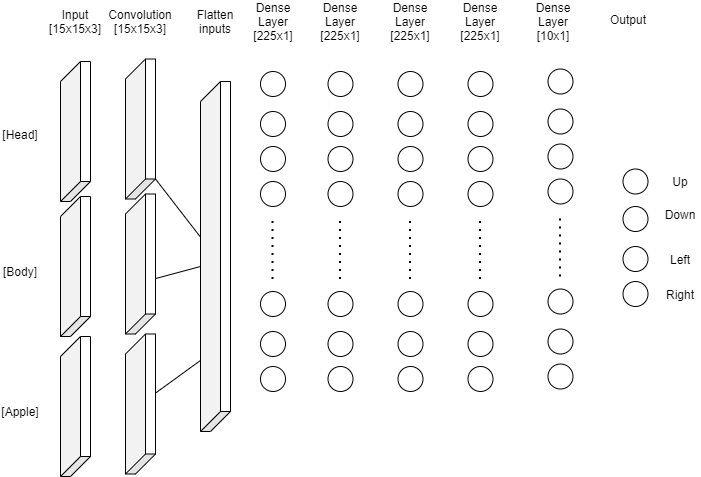


### The data

The data consists of features (15x15x3) and labels (a number 1-4 corresponding to a direction). The data is generated by playing the game manually.

### Training the classifier

I have programmed a simple snake game which can be found in `game.py`. The network for supervised learning can be found in `network.py`

In [2]:
import tensorflow as tf
import numpy as np
import network
from game import Game

# Some tensorflow setup
tf.executing_eagerly()
tf.keras.backend.set_floatx('float64')

# Import the data
features = tf.cast(np.load('dataset/features.npy'), 'float64')
labels = tf.cast(np.load('dataset/labels.npy'), 'float64')

# Instantiate the model
model = network.model()
model.summary()

# Train the model using the fit function and the dataset
model.fit(features, labels, epochs=14, batch_size=32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 3, 15, 15)         39        
_________________________________________________________________
flatten_1 (Flatten)          (None, 675)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 225)               152100    
_________________________________________________________________
dense_7 (Dense)              (None, 225)               50850     
_________________________________________________________________
dense_8 (Dense)              (None, 225)               50850     
_________________________________________________________________
dense_9 (Dense)              (None, 225)               50850     
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

If you want to see the model in action you can use the pre-trained model located in `saved_models` by running `python preview_model.py supervised` 

### The result

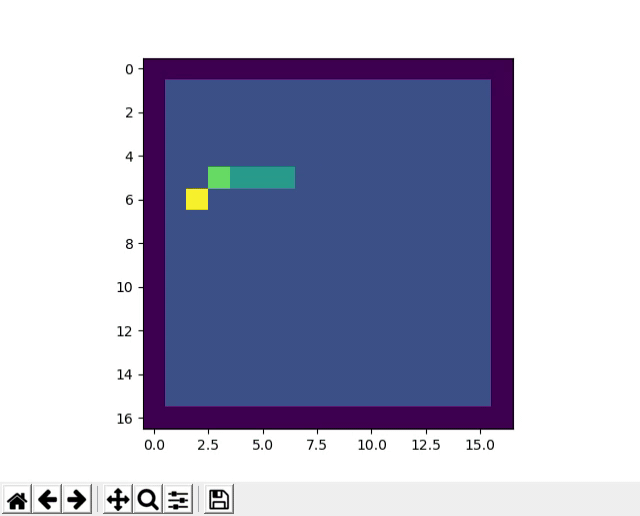

Given the relatively small amount of training data and the complexity of handling 675 input features, the results are pretty good. The snake scores an average of ~12 points and displays the ability to dodge its own body, althought its movement is sometimes erratic.


## Deep Reinforcement Learning

Deep reinforcement learning is an interpretation of reinforcement learning. A common variation of reinforcement learning is Q-learning, in which an agent (the snake) takes the world state as a matrix (Q-matrix) and explores this world. When the agent does something bad (like running into a wall), it gets punished for doing the actions that lead up to the bad action. When the agent does something good (like eating an apple), it gets rewarded with points, to encourage the behaviour that lead up to that point. 

Q-learning demands that the world state can be described completely with i.e. a matrix, which in many real world applications is impossible. For example, in chess, the possible combinations of pieces on the board are close to endless (according to some sources there are over *4.5*10^46* board states of chess). The same applies to snake, since there is a different state for each snake length, snake position and apple position. Therefore, deep reinforcement learning can be used to let a neural network estimate the Q-matrix instead 

I used a simpler network architecture for this challenge, given that the snake only has 12 features this time around. The network consists of the input layer, three dense layers with 16 neurons each, and an output layer.

### Training the classifier

The network for this classifier can be found in `simple_network.py`. The training algorithm for this part contains a bit more code than the first one, but essentially what it does is:

- Initialize the network with random weights close to zero
- Let the network play a game. For each move it makes, the game returns a reward
    - If the snake goes into a wall or itself, it gets a harsh punishment
    - If the snake hits nothing (survives), it gets a slight reward 
    - If the snake eats an apple, it gets a big reward
    - If the snake does not achieve anything for too long, it gets punished
- After the game is played, the network is trained with the recorded rewards
- This is repeated for 800 games

In the beginning, the network has a high *exploration factor*, meaning that it is forced to make random moves with a high probability. This is in order to explore new actions for a given state and not get stuck in "local optima" (e.g. move around in circles to try to survive)

In [ ]:
import tensorflow as tf
import numpy as np
import simple_network
from game import Game

# Create memory class to store actions and rewards for each game
class Memory:
    
    def __init__(self):
        self.clear()
    
    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []

    def add(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(float(reward))

# Define rewards for all results that can happen
rewards = {
    Game.HIT_APPLE : 100,
    Game.HIT_NOTHING : 0.5,
    Game.HIT_WALL : -50,
    Game.HIT_SELF : -10,
    Game.UNEVENTFUL : -1/2*Game.MAX_UNEVENTFUL_TIME
}

# Set a learning rate and amount of episodes
learning_rate = 0.01
episodes = 800

# Tensorflow setup
tf.keras.backend.set_floatx('float64')
model = simple_network.model()
optimizer = tf.keras.optimizers.Adam(learning_rate)

game = Game()
memory = Memory()

# Lookups and stats to see progress
lookups = {
    Game.HIT_APPLE : 'apples eaten',
    Game.HIT_WALL : 'wall-deaths',
    Game.HIT_SELF : 'suicides',
    Game.UNEVENTFUL : 'uneventful games',
    Game.HIT_NOTHING : 'valid, uneventful moves'
}
stats = {
    'apples eaten' : 0,
    'wall-deaths' : 0,
    'suicides' : 0,
    'uneventful games' : 0,
    'valid, uneventful moves' : 0,
}
high_score = 0

for n in range(episodes):
    
    # Reset the game state and clear memory
    game.reset()
    memory.clear()
    e = simple_network.epsilon(n, episodes)
    score = 0
    while True:
        state = game.get_vector() # Gets features as a 1*12 vector
        action = simple_network.get_action(model, game, e)
        feedback = game.update(action)
        stats[lookups[feedback]] += 1
        reward = rewards[feedback]
        if feedback == Game.HIT_APPLE:
            score += 1
        memory.add(
            state = state.reshape(12, 1),
            action = action,
            reward = reward
        )
        if feedback in [Game.HIT_SELF, Game.HIT_WALL, Game.UNEVENTFUL]:
            break

    if n%100 == 0:
        print('episode', n, 'stats:')
        print(stats)
    # Save the model every now and then
    if n%99 == 0:
        model.save('saved_models/model' + str(n/99)) #save a model for each generation
        
    simple_network.step(
        model, optimizer, 
        states = np.array(memory.states),
        actions = np.array(memory.actions),
        rewards = memory.rewards)

### Result

The training algorithm actually resulted in a pretty good model after ~300 episodes. Below is the result:
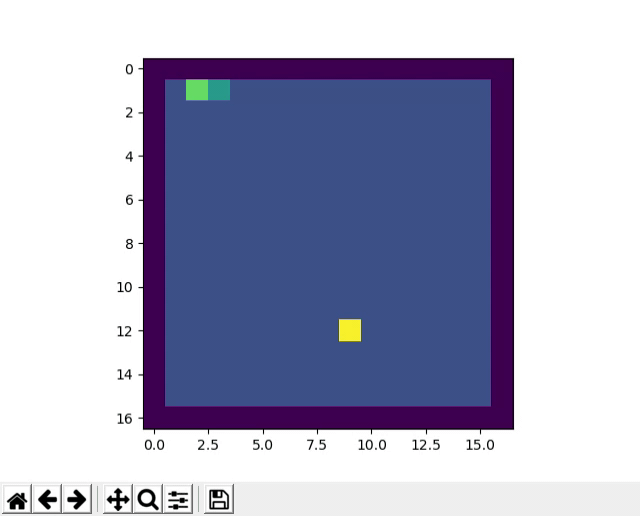

This snake takes a more careful approach to reach the apple, but it is pretty effective!